# DO Ecology Extraction

This notebook takes Ecology's bounding scenario model output files in NetCDF format (available at https://fortress.wa.gov/ecy/ezshare/EAP/SalishSea/SalishSeaModelBoundingScenarios.html) and extracts the bottom DO values at just the nodes of interest (based on the defined sections). A new NetCDF file is created.

The Ecology NetCDF files are over 370 GB each. The CDF file output by this notebook is much smaller, about 450 MB depending on the size of the domain, which makes later processing steps easier to repeat.

In [1]:
exist_cdf = "/home/benr/wqmodels/ssm/ecology_bounding_outputs/2008_SSM4_WQ_Exist1_nodes.nc"
reference_cdf = "/home/benr/wqmodels/ssm/ecology_bounding_outputs/2008_SSM4_WQ_Ref1_nodes.nc"

do_output_bottom_nc = "model_results/bottom do 2008.nc"
do_output_full_nc = "model_results/fulldepth do 2008.nc"
start = '2008.01.01'

var = {
    'Var_10': 'DOXG'
}

grid_file = 'SSM_Grid/ssm_grid.2dm'
sections_file = 'SSM_Grid/sections.ini'
sections = ['SJFElwha', 'UpperHaroToMainland']
masked_nodes_txt = 'gis/masked nodes.txt'

import configparser

from netCDF4 import Dataset
import numpy as np

from fvcom import FvcomGrid, ControlVolume, Transect, DepthCoordinate

Build the SSM grid and control volume objects so we know what note IDs to extract data for

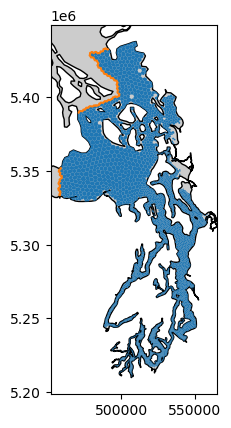

In [2]:
grid = FvcomGrid.from_mesh(grid_file)
ts = []
sections_config = configparser.ConfigParser()
sections_config.read(sections_file)
for s in sections:
    eles = np.array(sections_config[s]['waypoints'].split(' ')).astype(int)
    tr = Transect.shortest(grid, eles)
    ts.append(tr)
if masked_nodes_txt is not None:
    masked_nodes = set(np.loadtxt(masked_nodes_txt).astype(int))
else:
    masked_nodes = set()
cv = ControlVolume.from_transects(ts) - masked_nodes
ax = cv.plot()
for tr in ts:
    tr.plot(ax=ax, color='tab:orange')

In [3]:
exist = Dataset(exist_cdf)
ref = Dataset(reference_cdf)
exist

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): IJK(160120), Time(8760)
    variables(dimensions): float32 Var_1(Time, IJK), float32 Var_2(Time, IJK), float32 Var_3(Time, IJK), float32 Var_4(Time, IJK), float32 Var_5(Time, IJK), float32 Var_6(Time, IJK), float32 Var_7(Time, IJK), float32 Var_8(Time, IJK), float32 Var_9(Time, IJK), float32 Var_10(Time, IJK), float32 Var_11(Time, IJK), float32 Var_12(Time, IJK), float32 Var_13(Time, IJK), float32 Var_14(Time, IJK), float32 Var_15(Time, IJK), float32 Var_16(Time, IJK), float32 Var_17(Time, IJK), float32 Var_18(Time, IJK), float32 Var_19(Time, IJK), float32 Var_20(Time, IJK), float32 Var_21(Time, IJK), float32 Var_22(Time, IJK), float32 Var_23(Time, IJK), float32 Var_24(Time, IJK), float32 Var_25(Time, IJK), float32 Var_26(Time, IJK), float32 Var_27(Time, IJK), float32 Var_28(Time, IJK), float32 Var_29(Time, IJK), float32 Var_30(Time, IJK), float32 Var_31(Time, IJK), float32 Var_32(Time, 

Define the values of the dimension IJK we want.

IJK is a representation of the 10 depth points per node, zero-indexed, so to get the bottom points we need to multiply the node number minus 1 by 10 and add 9. For instance, if we wanted the bottom point of node 1 we'd get IJK index 9, and for node 2 we'd get IJK index 19. This simplifies to the expression in the cell below.

In [4]:
node_ids = np.array(cv.nodes_list)
ijk_index = node_ids * 10 - 1
display(ijk_index)
print(len(ijk_index))

array([ 28659,  29009,  29019, ..., 159939, 159999, 160029], shape=(4155,))

4155


Build the bottom layer output file

In [5]:
do_output = Dataset(do_output_bottom_nc, "w")
do_output.model_start = start
timeDim = do_output.createDimension('time', exist.dimensions['Time'].size)
nodeDim = do_output.createDimension('node', len(node_ids))
nodeVar = do_output.createVariable('node', "i4", ('node',))
hVar = do_output.createVariable('h', 'i4', ('node',))
xVar = do_output.createVariable('x', 'i4', ('node',))
yVar = do_output.createVariable('y', 'i4', ('node',))
do_output['node'][:] = node_ids
do_output['x'][:] = grid.nv[0,node_ids]
do_output['y'][:] = grid.nv[1,node_ids]
do_output['h'][:] = grid.nv[2,node_ids]
# Time values are not given in the Ecology output files, so recreate them based on a 1-hour
# (1/4-day) interval
timeVar = do_output.createVariable('time', "f4", ('time'))
do_output['time'][:] = np.arange(0, exist.dimensions['Time'].size/24, 1/24)
do_output

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2008.01.01
    dimensions(sizes): time(8760), node(4155)
    variables(dimensions): int32 node(node), int32 h(node), int32 x(node), int32 y(node), float32 time(time)
    groups: 

Copy data from Ecology's nc files to our bottom output

In [6]:
exist_data = {}
ref_data = {}
for v,n in var.items():
    existVar = do_output.createVariable(f'existing{n}_bottom', "f4", ('time','node'))
    refVar = do_output.createVariable(f'reference{n}_bottom', "f4", ('time','node'))
    print(f'Reading existing {n}')
    exist_data[n] = exist[v][:,ijk_index]
    print(f'Reading reference {n}')
    ref_data[n] = ref[v][:,ijk_index]
    do_output[f'existing{n}_bottom'][:] = exist_data[n]
    do_output[f'reference{n}_bottom'][:] = ref_data[n]

Reading existing DOXG
Reading reference DOXG


In [14]:
do_output.close()

Extract bottom DO at all depths (except the bottom-most, we already have that) and save all of them in a separate file

In [15]:
do_output = Dataset(do_output_full_nc, "w")
do_output.model_start = start
timeDim = do_output.createDimension('time', exist.dimensions['Time'].size)
nodeDim = do_output.createDimension('node', len(node_ids))
nodeVar = do_output.createVariable('node', "i4", ('node',))
hVar = do_output.createVariable('h', 'i4', ('node',))
xVar = do_output.createVariable('x', 'i4', ('node',))
yVar = do_output.createVariable('y', 'i4', ('node',))
do_output['node'][:] = node_ids
do_output['x'][:] = grid.nv[0,node_ids]
do_output['y'][:] = grid.nv[1,node_ids]
do_output['h'][:] = grid.nv[2,node_ids]
# Hard-coded for Ecology outputs
kb = 11
siglayDim = do_output.createDimension('siglay', kb - 1)
siglevDim = do_output.createDimension('siglev', kb)
dcoord = DepthCoordinate.from_asym_sigma(kb, grid, p_sigma=1.5)
siglayVar = do_output.createVariable('siglay', 'f4', ('siglay',))
siglevVar = do_output.createVariable('siglev', 'f4', ('siglev',))
do_output['siglay'][:] = dcoord.zz[:-1]
do_output['siglev'][:] = dcoord.z
timeVar = do_output.createVariable('time', "f4", ('time'))
do_output['time'][:] = np.arange(0, exist.dimensions['Time'].size/24, 1/24)
do_output

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2008.01.01
    dimensions(sizes): time(8760), node(4155), siglay(10), siglev(11)
    variables(dimensions): int32 node(node), int32 h(node), int32 x(node), int32 y(node), float32 siglay(siglay), float32 siglev(siglev), float32 time(time)
    groups: 

In [16]:
zetaVar = do_output.createVariable('zeta', 'f4', ('time','node'))
do_output['zeta'][:] = ref['Var_5'][:, (node_ids - 1)*10]

In [17]:
for ds,name in zip((exist,ref),('existing','reference')):
    for v,n in var.items():
        do_output.createVariable(f'{name}{n}', 'f4', ('time','siglay','node'))
        for z in range(kb - 2):
            print(f'Reading+writing {name} {n} level {z}')
            do_output[f'{name}{n}'][:,z,:] = ds[v][:, (node_ids - 1) * 10 + z]
for v,n in var.items():
    print(f'Writing existing {n} bottom')
    do_output[f'existing{n}'][:,-1,:] = exist_data[n]
    print(f'Writing reference {n} bottom')
    do_output[f'reference{n}'][:,-1,:] = ref_data[n]

Reading+writing existing DOXG level 0
Reading+writing existing DOXG level 1
Reading+writing existing DOXG level 2
Reading+writing existing DOXG level 3
Reading+writing existing DOXG level 4
Reading+writing existing DOXG level 5
Reading+writing existing DOXG level 6
Reading+writing existing DOXG level 7
Reading+writing existing DOXG level 8
Reading+writing reference DOXG level 0
Reading+writing reference DOXG level 1
Reading+writing reference DOXG level 2
Reading+writing reference DOXG level 3
Reading+writing reference DOXG level 4
Reading+writing reference DOXG level 5
Reading+writing reference DOXG level 6
Reading+writing reference DOXG level 7
Reading+writing reference DOXG level 8
Writing existing DOXG bottom
Writing reference DOXG bottom


In [18]:
do_output.close()